# Содержание

[1. Описание проекта](#1)

[2. Предобработка данных](#2)

[3. Иследовательский анализ данных](#3)

[4. Подготовка и обучение моделей](#4)

[5. Тестирование лучшей модели](#5)

[6. Заключение (Отчет)](#6)

<a id=1> </a>
# Прогнозирование оттока клиентов

### Описание проекта


Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Задача проекта
Задачей данной работы является построение модели по оттоку клиентов на основе предоставленных данных командой оператора. 
* Основная метрика: AUC-ROC. Она должна быть не менее 0.85
* Дополнительная метрика: Accuracy.

In [1]:
!pip install --q scikit-learn
!pip install --q matplotlib
!pip install --q seaborn
!pip install --q phik
!pip install --q imblearn
!pip install --q catboost

In [2]:
# Импорт всех необходимых библиотек для работы
import pandas as pd
import seaborn as sns
import warnings
import numpy as np
import time
import matplotlib.pyplot as plt
import phik

from phik.report import plot_correlation_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn import metrics

from catboost import CatBoostClassifier

pd.options.display.max_colwidth = None
random_state = 240423

warnings.filterwarnings('ignore')

<a id=2> </a>
# Предобработка данных 

### Изучение данных

In [3]:
# Напишем функция для чтения данных
def read_files(file):
    try:
        df_contract = pd.read_csv(f"/Users/pavelfedorov/Data_for_projects/{file}",
                                  index_col = 'customerID') 
        # так как столбец customerID содержится во всех таблицах, используем его как index
    except:
        df_contract = pd.read_csv(f"/datasets/{file}",
                                  index_col = 'customerID')
    return df_contract

In [4]:
df_contract = read_files("contract_new.csv")
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


In [5]:
df_contract.head(20)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68


In [6]:
df_contract.describe(include='all')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043.000000,7043
unique,77,67,3,2,4,NaN,6658
top,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


В таблице "contract_new" имеются данные о 7043 клиентах, пропуски отсутствуют.

Так как нам необходимо прогнозировать отток клиентов, целевым признаком для нас будет "EndDate". Дисбаланс классов 1 к 6

Описание признаков: 

* BeginDate – дата начала пользования услугами 
* EndDate – дата окончания пользования услугами,
* Type – тип оплаты: ежемесячный, годовой и тд (больше половины имеют тип оплаты - ежемесячный)
* PaperlessBilling – безналичный расчет (больше людей предпочитают безналичный расчет 4:3)
* PaymentMethod – способ оплаты (4 типа оплаты, наиболее популярный - Electronic check)
* MonthlyCharges – ежемесячные траты на услуги (Среднее значение сильно выше медианного, необходимо посмотреть аномалии в данном признаке)
* TotalCharges – всего потрачено денег на услуги (Тип данных object привести к числовому признаку и дополнительно проанализировать) 

In [7]:
df_personal = read_files('personal_new.csv')
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [8]:
df_personal.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [9]:
df_personal.describe(include='all')

,gender,SeniorCitizen,Partner,Dependents
count,7043,7043.000000,7043,7043
unique,2,NaN,2,2
top,Male,NaN,No,No
freq,3555,NaN,3641,4933
mean,NaN,0.162147,NaN,NaN
std,NaN,0.368612,NaN,NaN
min,NaN,0.000000,NaN,NaN
25%,NaN,0.000000,NaN,NaN
50%,NaN,0.000000,NaN,NaN
75%,NaN,0.000000,NaN,NaN


В таблице "personal_new" имеются данные о 7043 клиентах, пропуски отсутствуют.

Описание признаков:

* gender - пол клиента (выборка весьма сбалосирована по полу клиента)
* Senior Citizen – наличие пенсионного статуса по возрасту (пенсионеров 16,2%) 
* Partner – наличие супруга(и) (выборка весьма сбалосирована по наличию супруга)
* Dependents – наличие иждивенцев (У 30% клиентов есть иждивенцы)

In [10]:
df_internet = read_files('internet_new.csv')
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [11]:
df_internet.head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
df_internet.describe(include='all')

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


В таблице "internet_new" имеются данные о 5517 клиентах, пропуски отсутствуют. Предполагаю, что остальные клиенты не пользуются интернетом

Описание признаков:

* InternetService - Тип подключения 
* OnlineSecurity - Блокировка небезопасных сайтов
* OnlineBackup - Облачное хранилище файлов для резервного копирования данных
* DeviceProtection  - Антивирус
* TechSupport - Выделенная линия технической поддержки
* StreamingTV - Стриминговое телевидение
* StreamingMovies - Каталог фильмов

In [13]:
df_phone = read_files('phone_new.csv')
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [14]:
df_phone.head()

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [15]:
df_phone.describe(include='all')

,MultipleLines
count,6361
unique,2
top,No
freq,3390


В таблице "phone_new" имеются данные о 6361 клиентах, пропуски отсутствуют. Предполагаю, что остальные клиенты не пользуются телефоном

Описание признака: 

* MultipleLines – наличие возможности ведения параллельных линий во время 
звонка

### Объединение данных

In [16]:
df = df_contract.merge(df_personal, how = 'outer', left_index=True, right_index=True)
df = df.merge(df_internet, how = 'outer', left_index=True, right_index=True)
df = df.merge(df_phone, how = 'outer', left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

In [17]:
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,631.73,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No
0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,539.1,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes
0004-TLHLJ,2019-09-01,No,Month-to-month,Yes,Electronic check,73.9,406.45,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
0011-IGKFF,2018-12-01,No,Month-to-month,Yes,Electronic check,98.0,1372.0,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
0013-EXCHZ,2019-09-01,No,Month-to-month,Yes,Mailed check,83.9,444.67,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No


### Обработка признаков, создание целевого признака

Создадим целевой признак из столбца "EndDate"

In [18]:
df['target'] = df.apply(lambda row: 0 if row['EndDate'] == 'No' else 1, axis=1)

Преобразуем значения столбца 'TotalCharges' из строкого типа в вещественный. 

In [19]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

Посмотрим, по какой причине образовались пропуски.

In [20]:
df[df['TotalCharges'].isna()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target
customerID,,,,,,,,,,,,,,,,,,,,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
2775-SEFEE,2020-02-01,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,Male,0,No,Yes,DSL,Yes,Yes,No,Yes,No,No,Yes,0
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0


Можно заметить что это новые клиенты так как дата "BeginDate" соответствует дате актуальности таблицы. Чтобы не осталять пустые значения зааполним их, значениями из столбца 'MonthlyCharges'

In [21]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])

Создадим новый признак - период на протяжении которого клиент пользуется услугами

In [22]:
# Функция для создания столбца с кол-вом дней, в течении которых клиент пользуется услугами
def client_time_func(row):
    if row['EndDate'] == 'No':
        client_time = (pd.to_datetime('2020-02-01', format='%Y-%m-%d') 
                       - pd.to_datetime(row['BeginDate'], format='%Y-%m-%d'))
    else: 
        client_time = (pd.to_datetime(row['EndDate'], format='%Y-%m-%d') 
                         - pd.to_datetime(row['BeginDate'], format='%Y-%m-%d'))
    return client_time     

In [23]:
# Применим функцию для создания столбца, преобразуем столбец в тип данных int
df['client_time'] = df.apply(client_time_func, axis=1).dt.days

Преобразуем значения столбца 'SeniorCitizen' из вещественного типа в строковый. 

In [24]:
df['SeniorCitizen'] = df.apply(lambda row: 'No' if row['SeniorCitizen'] == 0 else 'Yes', axis=1)

### Обработка дубликатов

In [25]:
df[df.duplicated()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,client_time
customerID,,,,,,,,,,,,,,,,,,,,,
2668-TZSPS,2020-01-01,No,Month-to-month,No,Mailed check,20.45,20.45,Male,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,31
4376-KFVRS,2014-02-01,No,Two year,Yes,Credit card (automatic),114.05,8211.60,Male,No,Yes,...,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0,2191
8605-ITULD,2020-01-01,No,Month-to-month,No,Mailed check,19.55,19.55,Female,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,31
8774-GSBUN,2014-02-01,No,Two year,No,Mailed check,25.40,1828.80,Male,No,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,2191


In [26]:
print(f'Количество явных дубликатов - {df.duplicated().sum()}')

Количество явных дубликатов - 4


In [27]:
# удалим явные дубликаты
df = df.drop_duplicates()

### Обработка аномалий

<AxesSubplot:xlabel='MonthlyCharges'>

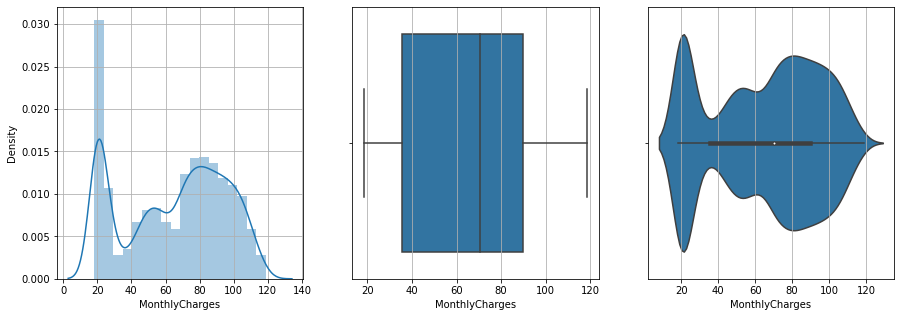

In [28]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.grid()
sns.distplot(df['MonthlyCharges'])

plt.subplot(1,3,2)
plt.grid()
sns.boxplot(x=df['MonthlyCharges'])

plt.subplot(1,3,3)
plt.grid()
sns.violinplot(x=df['MonthlyCharges'])

Аномалии в столбце "MonthlyCharges" отсутствуют

<AxesSubplot:xlabel='TotalCharges'>

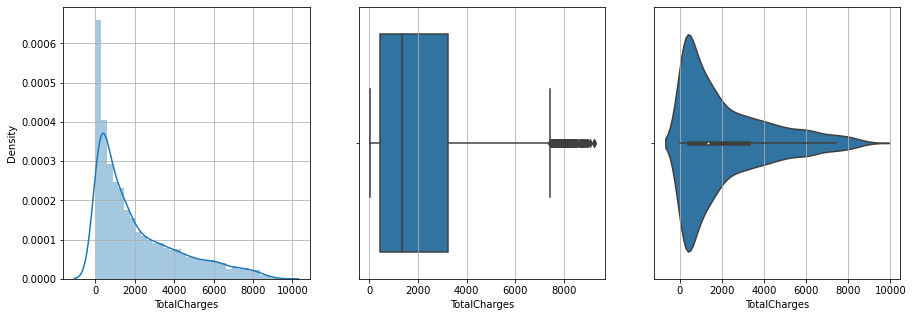

In [29]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.grid()
sns.distplot(df['TotalCharges'])

plt.subplot(1,3,2)
plt.grid()
sns.boxplot(x=df['TotalCharges'])

plt.subplot(1,3,3)
plt.grid()
sns.violinplot(x=df['TotalCharges'])

Есть небольшое количество выбросов выше 7,5 тыс у.е. Посмотрим кто входит в эти выбросы:

In [30]:
df[df['TotalCharges']>7500]['BeginDate'].value_counts()

2014-02-01    98
2014-03-01    26
2014-04-01    14
2014-05-01    11
2014-06-01     9
2014-08-01     8
2014-10-01     3
2014-07-01     3
2013-10-01     2
2013-11-01     2
2014-11-01     1
2014-09-01     1
2015-02-01     1
2014-12-01     1
Name: BeginDate, dtype: int64

Как оказалось, это старые клиенты 2013-2015гг. Их было немного.

### Обработка пропусков

Заполним все пропуски значением "No", считаем что если клиент отсутстует в таблице internet или phone, то он не пользуется данными услугами.

In [31]:
df = df.fillna('No')

<a id=3> </a>
# Иследовательский анализ данных

### Проверка корреляции числовых признаков на наличие мультиколлинеарности

In [32]:
interval_cols = ['MonthlyCharges', 'TotalCharges','client_time']
phik_overview = df.phik_matrix(interval_cols=interval_cols)

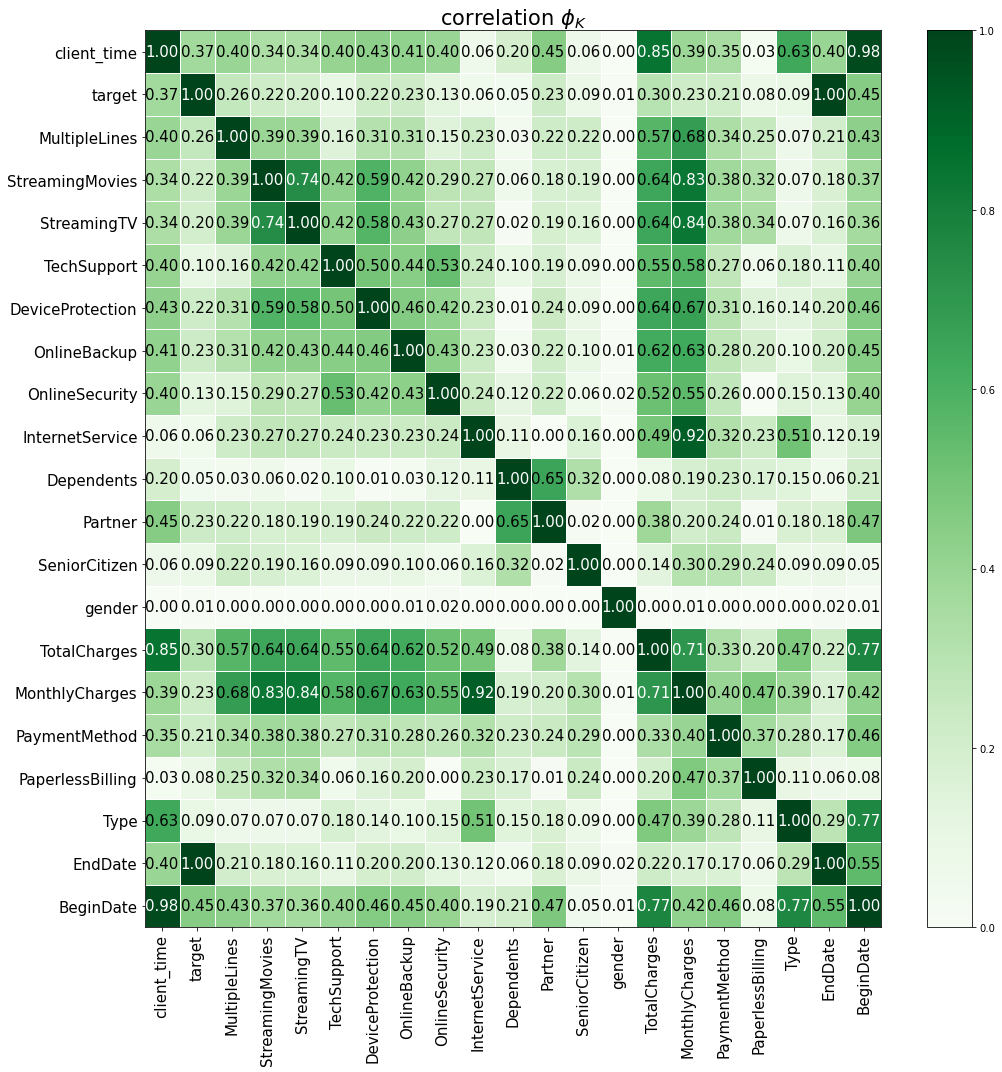

In [33]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 15))
plt.tight_layout()

Можно отметить, что в столбце 'gender' почти отсутствует корреляция с остальными столбцами, можно отказаться от данного признака при построении модели. Также необходимо удалить признаки "BeginDate" и "EndDate" чтобы избежать утечки.
С мультиколериальностью будем бороться регуляризацией, поэтому все фичи оставляем

### Посмотреть распределение данных по отношению к целевому признаку

In [34]:
def make_plot(column):
    plt.figure(figsize=(10,4))
    plt.title(f'Распределение по столбцу {column}')
    sns.countplot(data=df, x=column, hue='target')
    plt.legend(title='Отток клиентов') 
    return plt.show()

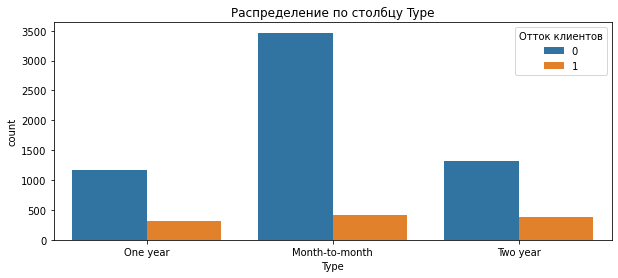

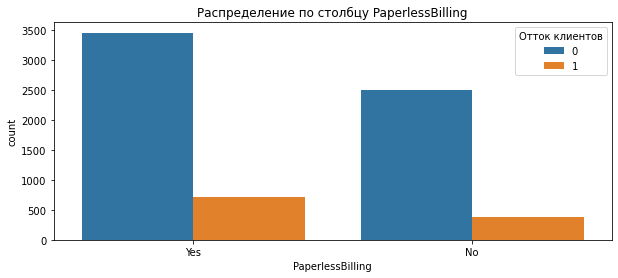

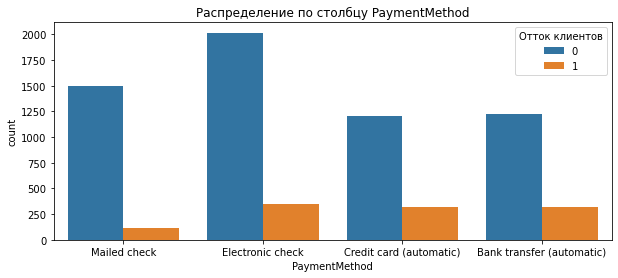

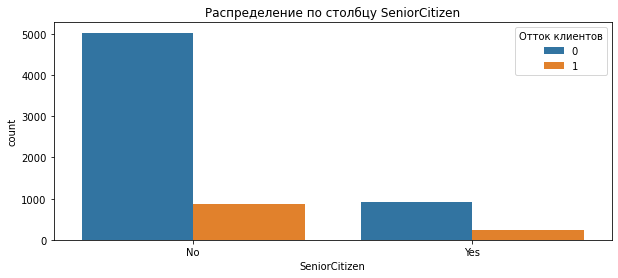

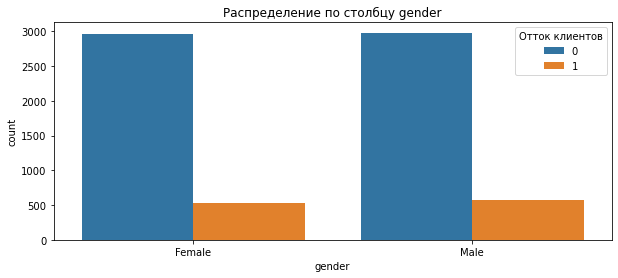

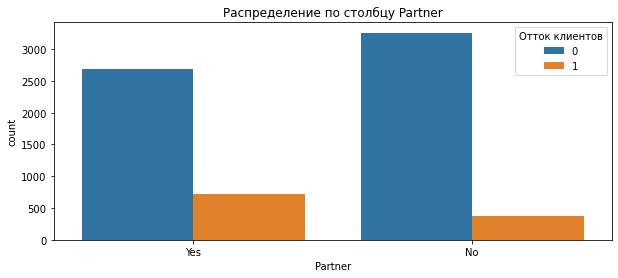

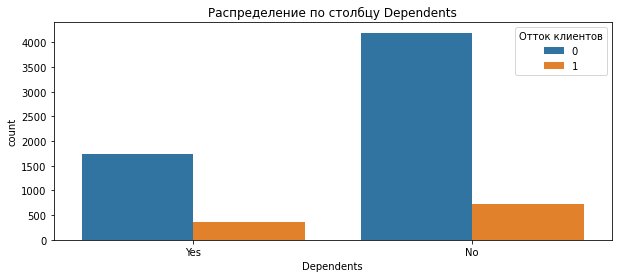

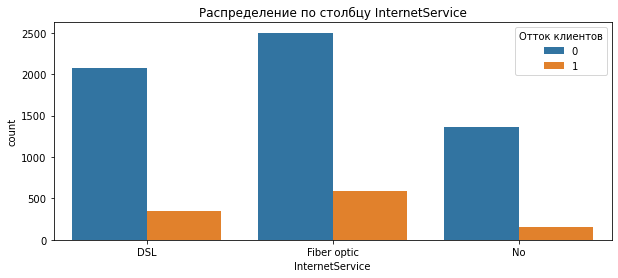

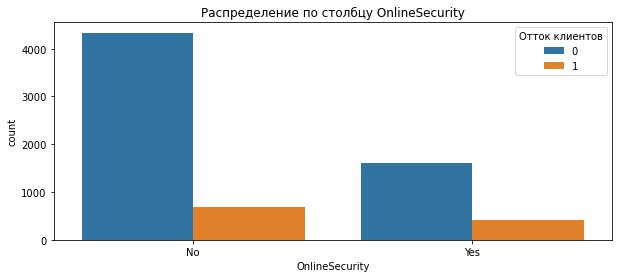

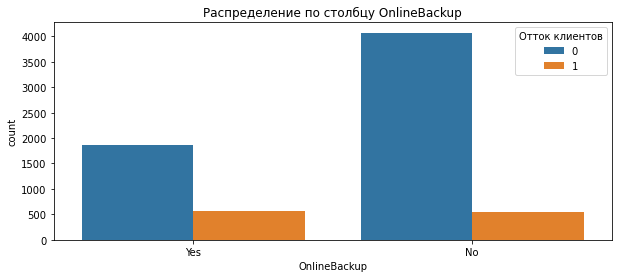

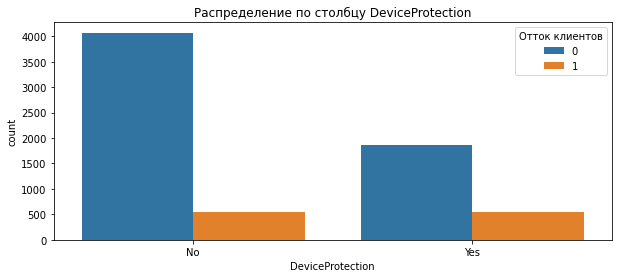

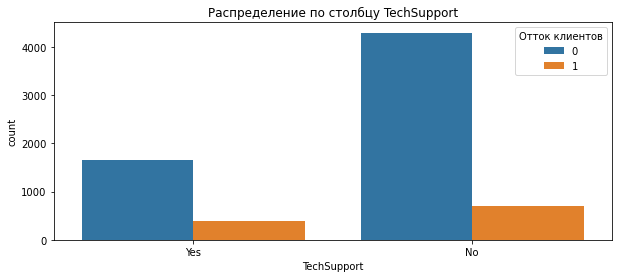

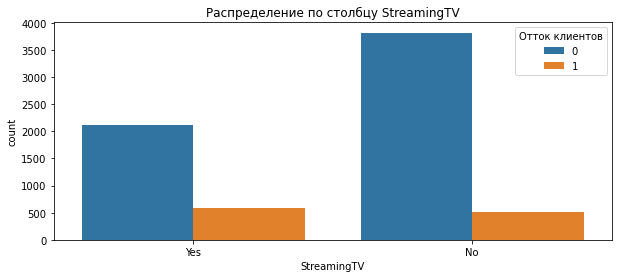

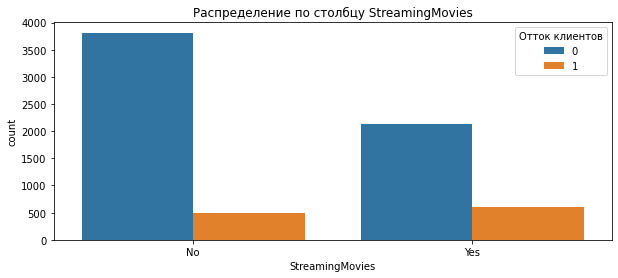

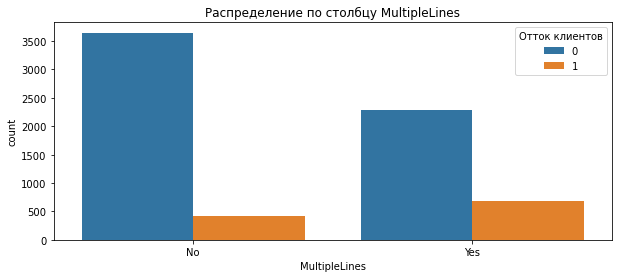

In [35]:
l = [ 'Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'gender', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines']
for i in l:
    make_plot(i)   

По анализу категориальных переменных можно сделать следующие гипотезы:

* Клиенты с способом оплаты каждый год или каждые 2 года, чаще уходят по сравнению с клиентами которые имеют способ оплаты каждый месяц.
* Клиенты без супруга(и) реже уходят.
* У клиентов которые ушли, чаще были подключены разные дополнительные услуги.

In [36]:
def make_plot_2(column):
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.title('Действующие клиенты')
    sns.distplot(df[df['target'] == 0][column])

    plt.subplot(1,2,2)
    plt.title('Ушедшие клиенты')
    sns.distplot(df[df['target'] == 1][column])

    return plt.show()

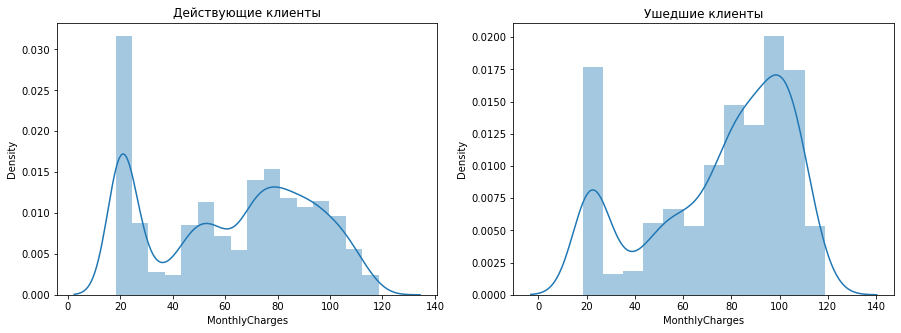

In [37]:
make_plot_2('MonthlyCharges')

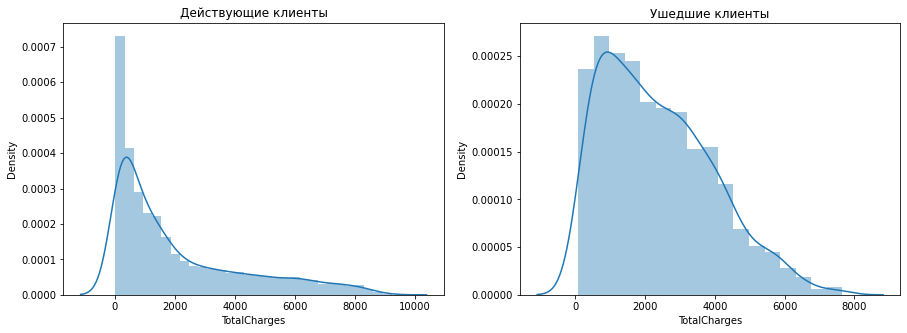

In [38]:
make_plot_2('TotalCharges')

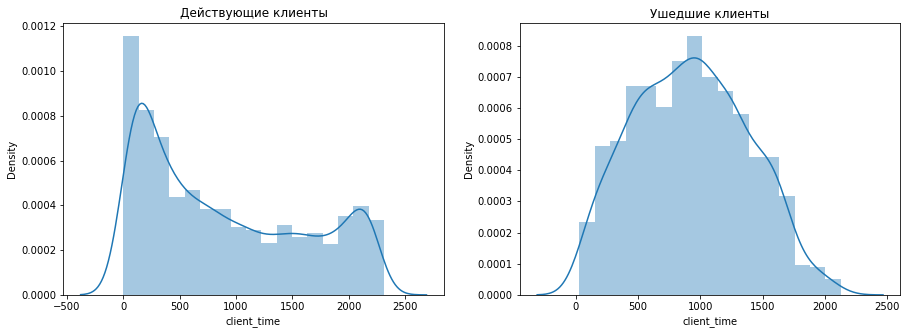

In [39]:
make_plot_2('client_time')

По анализу числовых переменных можно сделать следующие гипотезы:

* Ушедшие клиенты часто платили высокую Ежемесячную плату, возможно по этой причине они и уходили.
* В нашей выборке наибольший отток клиентов произошол после 3-х лет пользования.

<a id=4> </a>
# Подготовка и обучение моделей

### Подготовка признаков для моделей

In [40]:
#Приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

In [41]:
# Разделим датафрейм на фичи и таргет
features = df.drop(['begindate','enddate','target','gender'], axis = 1)
target = df['target']

### Разделение на тестовую и обучающую выборку

In [42]:
# Сделаем тестовую выборку размером 0.25 согласно ТЗ
features_train, features_test, target_train, target_test  = train_test_split(features, 
                                                                             target, 
                                                                             test_size=0.25, 
                                                                             random_state=random_state,
                                                                             stratify = target)
# Проверим как поделились признаки
print('Признаки обучающей выборки:',features_train.shape)  
print('Целевой признак обучающей выборки:', target_train.shape)
print('Признаки тестовой выборки:',features_test.shape)  
print('Целевой признак тестовой выборки:', target_test.shape)

Признаки обучающей выборки: (5279, 17)
Целевой признак обучающей выборки: (5279,)
Признаки тестовой выборки: (1760, 17)
Целевой признак тестовой выборки: (1760,)


In [43]:
# Выделим категориальные и вещественные фичи
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
num_features = features_train.select_dtypes(exclude='object').columns.to_list()

In [44]:
# Подготовим трансформер для Pipeline
transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features
    ),
    (
        StandardScaler(), 
        num_features
    )
)
# Для устранения дисбаланса классов будем использовать SMOTE в Pipline
smt = SMOTE(random_state=random_state)

### Обучение первой модели

В качестве первой модели используем логистическую регрессию.

In [45]:
model_LR = LogisticRegression(random_state=random_state)

In [46]:
pipeline_LR = Pipeline(steps=[('transformer', transformer), # Преобразование признаков OneHotEncoder и StandardScaler
                              ('smote', smt), # Балансировка признаков
                              ('model_LR', model_LR) # Модель Логистической регрессии
                              ])

Так как нам нужно оценить 2 метрики, создадим словарь с ними для GridSearchCV, данный словарь будем ипользовать и в других моделях.

In [47]:
# Словарь с основными метриками
scoring = {"AUC": "roc_auc", "Accuracy": "accuracy"}

In [48]:
# Для перебора параметров в GridSearchCV
param_grid_LR = {
    'model_LR__C': range(1,100),
    'model_LR__penalty': ['l1', 'l2']
}

In [49]:
clf_LR_GS = GridSearchCV(pipeline_LR, 
                      param_grid_LR, 
                      scoring=scoring,
                      refit="AUC", # Укажем основную метрику для подбора
                      cv = 7, 
                      n_jobs=-1)
clf_LR_GS.fit(features_train, target_train)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['type',
                                                                          'paperlessbilling',
                                                                          'paymentmethod',
                                                                          'seniorcitizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internetservice',
                                                                          'onlinesecurity',
                                                                          'onlinebackup',
                                                                          'deviceprotection',
                                                                          'techsupport',
                                                                          'streamingtv',
                                                                          'streamingmovies',
                                                                          'multiplelines']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['monthlycharges',
                                                                          'totalcharges',
                                                                          'client_time'])])),
                                       ('smote', SMOTE(random_state=240423)),
                                       ('model_LR',
                                        LogisticRegression(random_state=240423))]),
             n_jobs=-1,
             param_grid={'model_LR__C': range(1, 100),
                         'model_LR__penalty': ['l1', 'l2']},
             refit='AUC', scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'})

In [50]:
gs_LR_best_score = clf_LR_GS.best_score_
gs_LR_best_params = clf_LR_GS.best_params_
print(f'Лучшее значение ROC-AUC для Логистической регрессии: {round(gs_LR_best_score,4)}')
print(f'Параметры модели: {gs_LR_best_params}')

Лучшее значение ROC-AUC для Логистической регрессии: 0.7656
Параметры модели: {'model_LR__C': 1, 'model_LR__penalty': 'l2'}


In [51]:
results_LR = pd.DataFrame(clf_LR_GS.cv_results_)
LR_acc = results_LR['mean_test_Accuracy'].mean()
print('Доля правильных ответов Логистической регрессии:', round(LR_acc,4))

Доля правильных ответов Логистической регрессии: 0.6997


### Обучение второй модели

В качестве второй модели используем модель случайного леса:

In [52]:
model_rf = RandomForestClassifier(random_state=random_state)

In [53]:
pipeline_rf = Pipeline(steps=[('transformer', transformer),
                              ('smote', smt),
                              ('model_RF', model_rf) # Модель случайный лес
                              ])

In [54]:
# Для перебора параметров в GridSearchCV
param_grid_rf = {
    'model_RF__n_estimators': range(150, 251, 50),
    'model_RF__max_depth': range(7, 12),
    'model_RF__min_samples_split': (3, 4),
    'model_RF__min_samples_leaf': (1, 2)
}

In [55]:
start = time.time() 
clf_RF_GS = GridSearchCV(pipeline_rf, 
                      param_grid_rf, 
                      scoring=scoring,
                      refit="AUC", 
                      cv = 7,
                      n_jobs=-1)
clf_RF_GS.fit(features_train, target_train)
end = time.time() - start
print('Время перебора в секундах:', round(end))

Время перебора в секундах: 88


In [56]:
gs_RF_best_score = clf_RF_GS.best_score_
gs_RF_best_params = clf_RF_GS.best_params_
print(f'Лучшее значение ROC-AUC для Случайного леса: {round(gs_RF_best_score,4)}')
print(f'Параметры модели: {gs_RF_best_params}')

Лучшее значение ROC-AUC для Случайного леса: 0.8217
Параметры модели: {'model_RF__max_depth': 9, 'model_RF__min_samples_leaf': 2, 'model_RF__min_samples_split': 3, 'model_RF__n_estimators': 200}


In [57]:
results_RF = pd.DataFrame(clf_RF_GS.cv_results_)
RF_acc = results_RF['mean_test_Accuracy'].mean()
print('Доля правильных ответов модели случайного леса:', round(RF_acc,4))

Доля правильных ответов модели случайного леса: 0.8043


### Обучение третьей модели

In [58]:
model_cat = CatBoostClassifier(random_state=random_state,logging_level = 'Silent')

In [59]:
pipeline_cat = Pipeline(steps=[('transformer', transformer),
                               ('smote', smt),
                               ('model_cat', model_cat)  # Модель градиентного бустинга CatBoost
                               ])

In [60]:
param_grid_cat = {'model_cat__learning_rate': [0.03, 0.1],
                  'model_cat__depth': [4, 6],
                  'model_cat__l2_leaf_reg': [1, 3]}

In [61]:
start = time.time() 
clf_cat_GS = GridSearchCV(pipeline_cat, 
                      param_grid_cat, 
                      scoring=scoring,
                      refit="AUC", 
                      cv = 7, 
                      n_jobs=-1)
clf_cat_GS.fit(features_train, target_train)
end = time.time() - start
print('Время перебора в секундах:', round(end))

Время перебора в секундах: 55


In [62]:
gs_cat_best_score = clf_cat_GS.best_score_
gs_cat_best_params = clf_cat_GS.best_params_
print(f'Лучшее значение ROC-AUC модели градиентного бустинга CatBoost: {round(gs_cat_best_score,4)}')
print(f'Параметры модели: {gs_cat_best_params}')

Лучшее значение ROC-AUC модели градиентного бустинга CatBoost: 0.9151
Параметры модели: {'model_cat__depth': 4, 'model_cat__l2_leaf_reg': 1, 'model_cat__learning_rate': 0.1}


In [63]:
results_cat = pd.DataFrame(clf_cat_GS.cv_results_)
cat_acc = results_cat['mean_test_Accuracy'].mean()
print('Доля правильных ответов  модели градиентного бустинга CatBoost:', round(cat_acc,4))

Доля правильных ответов  модели градиентного бустинга CatBoost: 0.9044


### Результат

В результате лучшей моделью стала модель градиентного бустинга - CatBoost. 
Метрика ROC-AUC не менее 0.85 была достигнута.

<a id=5> </a>
# Тестирование лучшей модели

In [64]:
final_model_probability =clf_cat_GS.predict_proba(features_test)
final_model_predict =clf_cat_GS.predict(features_test)
final_model_AUC = roc_auc_score(target_test,final_model_probability[:,1])
final_model_ACC = accuracy_score(target_test,final_model_predict)
print('Значение ROC-AUC лучшей модели на тесте', round(final_model_AUC,4))
print('Доля правильных ответов  лучшей модели на тесте', round(final_model_ACC,4))

Значение ROC-AUC лучшей модели на тесте 0.9163
Доля правильных ответов  лучшей модели на тесте 0.9233


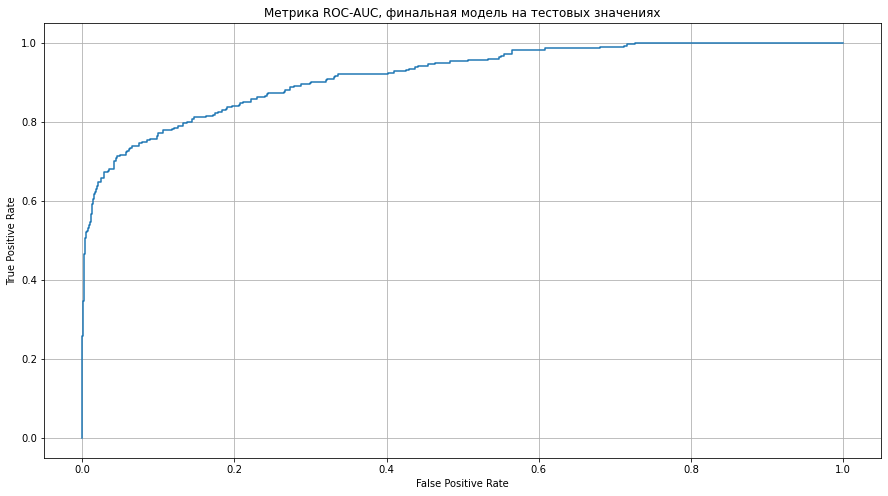

In [65]:
fpr, tpr, _ = metrics. roc_curve (target_test, final_model_probability[:,1])

plt.figure(figsize=(15,8))
plt.plot (fpr,tpr)
plt.grid()
plt.title('Метрика ROC-AUC, финальная модель на тестовых значениях')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

Выводы:

* Лучшей моделью оказалась модель градиентного бустинга - CatBoost. 
* Был достигнут высокий показатель основной метрики на кросс-валидации ROC-AUC - 0.9151, Доля правильных ответов составила 0.9044
* На тесте мы получили значения лучше: ROC-AUC - 0.9163 и доля правельных ответов - 0.9233.
* Параметры модели: 

        * depth (глубина дерева) - 4 
        * l2_leaf_reg (коэффициент регуляризации L2): 1
        * learning_rate (скорость обучения): 0.1

In [66]:
features_transformer = clf_cat_GS.best_estimator_.named_steps["transformer"].get_feature_names_out()
features_transformer = [x.split('__')[1] for x in features_transformer]

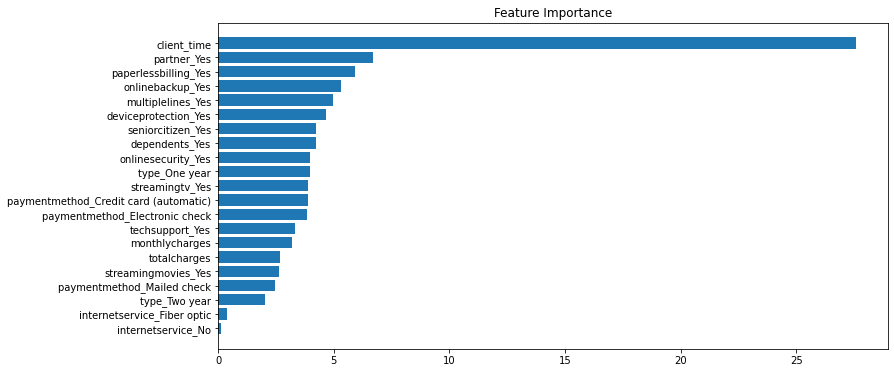

In [67]:
feature_importance = clf_cat_GS.best_estimator_._final_estimator.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_transformer)[sorted_idx])
plt.title('Feature Importance')
plt.show()

<a id=6> </a>
# Заключение (Отчет)

Оператор связи «Ниединогоразрыва.ком» поставил задачу построения модели по оттоку клиентов на основе данных предоставленных командой оператора. Необходимо было получить основную метрику: AUC-ROC не менее 0.85, а также оценить дополнительную метрику: Accuracy.

После изучения данных были сделаны следующие действия:

* Выделен целевой признак из столбца "Enddate";
* Создан новый признак "продолжительность пользования услугами оператора" при помощи столбцов "Begindate" и "Enddate";
* Подготовлены признаки для анализа.
* Явные дубликаты были удалены 
* Аномали не удалялись
* Пропуски были заполнены значением "No", т.е. клиент не пользуется данными услугами

Данные были проверены на корреляцию для оценки признаков, после оценки было принято решение об удалении признака 'gender', т.к. он имеет слабую корреляцию со всеми признаками

По результатам иследовательского анализа данных были сделаны следующие гипотезы:

* Клиенты с способом оплаты каждый год или каждые 2 года, чаще уходят по сравнению с клиентами которые имеют способ оплаты каждый месяц.
* Клиенты без супруга(и) реже уходят.
* У клиентов которые ушли, чаще были подключены разные дополнительные услуги.
* Ушедшие клиенты часто платили высокую Ежемесячную плату
* В нашей выборке наибольший отток клиентов произошол после 3-х лет пользования.

Для обучения моделей мы использовали признаки на основе предоставленных данных:

* Type – тип оплаты: ежемесячный, годовой и тд
* PaperlessBilling – безналичный расчет 
* PaymentMethod – способ оплаты 
* MonthlyCharges – ежемесячные траты на услуги 
* TotalCharges – всего потрачено денег на услуги 
* Senior Citizen – наличие пенсионного статуса по возрасту 
* Partner – наличие супруга(и) 
* Dependents – наличие иждивенцев 
* InternetService - Тип подключения 
* OnlineSecurity - Блокировка небезопасных сайтов
* OnlineBackup - Облачное хранилище файлов для резервного копирования данных
* DeviceProtection  - Антивирус
* TechSupport - Выделенная линия технической поддержки
* StreamingTV - Стриминговое телевидение
* StreamingMovies - Каталог фильмов
* MultipleLines – наличие возможности ведения параллельных линий во время звонка

А также созданный признак:

* client_time - продолжительность пользования услугами оператора в днях

При разделении на тестовую и обучающую выборку, размер тестовой выборки составил 0.25, была задана пропорция классов по целевой метрике.
Также был зафиксирован генератор случайных чисел датой начала проработки проекта - Random_state = 240423

Для решения задачи классификации мы анализровали 3 модели:

* Логистическая регрессия
* Cлучайный лес
* Градиентный бустинг - CatBoost

Для всех моделей мы использовали:
* Преобразование категориальных признаков при помощи OneHotEncoder
* Cтандартизация вещественных признаков при помощи StandardScaler
* Балансировка таргета методом SMOTE

Лучшей моделью оказалась модель - градиентного бустинга (CatBoost) со следующими параметрами:

* depth (глубина дерева) - 4 
* l2_leaf_reg (коэффициент регуляризации L2): 1
* learning_rate (скорость обучения): 0.1

Все остальные параметры были использованы по умолчанию

В результате были получены:

* ROC-AUC лучшей модели на кросс-валидации - 0.9151, на тесте 0.9163
* Доля правельных ответов лучшей модели на кросс-валидации - 0.9044, на тесте 0.9233

Дополнительно был проведен анализ важности признаков для лучшей модели, выделил топ 10 с указанием важности:

* 'client_time' (продолжительность пользования услугами оператора в днях) - 27.58 %
* 'partner' (наличие супруга(и)) - 6.70 %
* 'paperlessbilling' (безналичный расчет) - 5.91%
* 'onlinebackup' (облачное хранилище файлов для резервного копирования данных) - 5.30 %
* 'multiplelines' (наличие возможности ведения параллельных линий во время звонка)  - 4.96%
* 'deviceprotection' (наличие антивируса) - 4.66%
* 'seniorcitizen' (наличие пенсионного статуса по возрасту) - 4.25%
* 'dependents' (наличие иждивенцев) - 4.24%
* 'onlinesecurity' (наличие блокировки небезопасных сайтов) - 3.99%
* 'type_One year' (тип оплаты - годовой) - 3.99%

Все пункты были выполнены согласно плану. 

Самое трудной в данной работе на мой взгляд это избегание утечки данных. Советую выполнять работу через Pipline - это сильно упрощает работу.

Ключевой этап в данной работе, на мой взгляд - это подготовка признаков, тк признак, который был создан, лучше всего повлиял на основную метрику, по результату анализа важности признаков.